# Анализ программы лояльности сети строительных магазинов 

Цель: проанализировать программу лояльности и определить, эффективна ли программа лояльности и дать рекомендации по ее развитию. 

Задачи: 

- Провести исследовательский анализ данных;
- Провести анализ программы лояльности;
- Сформулировать и проверить статистические гипотезы.


### Часть 1. Загрузка библиотек и открытие дата-сета и знакомство с данными

In [194]:
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy.stats import ttest_ind  as st
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib.ticker import FuncFormatter
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from io import BytesIO
import requests
from datetime import timedelta

In [195]:
#открываем дата-сет для первичного просмотра 
retail = pd.read_csv ('/datasets/retail_dataset.csv')
display (retail) 



,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00
...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,NaN,Shop 0,0.00
105331,540247,21742,0,2017-01-05 15:56:00,21143.00,Shop 0,0.00
105332,538068,85048,1,2016-12-09 14:05:00,23657.00,Shop 0,1.00
105333,538207,22818,11,2016-12-10 11:33:00,18427.00,Shop 0,0.00


In [196]:
retail.describe ()
retail.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [197]:
#узнаем основную инфорамцию о данных в колонках дата-сета
print ('Всего уникальных покупателей:', retail ['CustomerID'].nunique ())

print ('Всего уникальных товаров:', retail ['item_ID'].nunique ())

print ('Участие в программе лояльности обозначается следующим образом:', retail ['loyalty_program'].unique())

print ('Уникальные названия магазинов:', retail ['ShopID'].unique())

Всего уникальных покупателей: 1749
Всего уникальных товаров: 3159
Участие в программе лояльности обозначается следующим образом: [0. 1.]
Уникальные названия магазинов: ['Shop 0' 'Shop 1' 'Shop 4' 'Shop 6' 'Shop 2' 'Shop 11' 'Shop 3' 'Shop 5'
 'Shop 7' 'Shop 12' 'Shop 8' 'Shop 27' 'Shop 10' 'Shop 20' 'Shop 19'
 'Shop 25' 'Shop 14' 'Shop 21' 'Shop 18' 'Shop 9' 'Shop 16' 'Shop 28'
 'Shop 29' 'Shop 17' 'Shop 22' 'Shop 13' 'Shop 26' 'Shop 24' 'Shop 15'
 'Shop 23' 'Shop 30']


In [198]:
#откроем второй дата-сет
products = pd.read_csv ('datasets/product_codes.csv')
display (products)

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
...,...,...
9964,84306,8.29
9965,90001A,4.15
9966,90118,2.46
9967,DOT,172.62


Вывод: среди всех продуктов явно выделяется DOT. Вероятнее всего, речь идет о доставке. 

In [199]:
products.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [200]:
print ('Уникальных наименований продуктов:', products  ['productID']. nunique ())
print ('Количество уникальнных ценников:', products  ['price_per_one']. nunique ())

Уникальных наименований продуктов: 3159
Количество уникальнных ценников: 586


<b>Вывод:</b> 
Загрузили необходимые библиотеки и познакомились с двумя необходимыми дата-сетами. 
Удалось выяснить, что дата-сете, содержащем информацию о покупках и чеках, содержится: 
- всего уникальных покупателей: 1749
- всего уникальных товаров: 3159

В дата-сете о продуктах и их стоимостях содержатся: 
- уникальных наименований продуктов: 3159
- количество уникальнных ценников: 586

### Часть 2. Предобработка данных 

В этой части проекта в приведем к правильным форматам данные, удалим лишнее и заполним пропуски, а так же совместим 2 таблицы. 

In [201]:
#изменим названия столбцов
retail.columns = ['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id', 'shop_id', 'loyalty_program']

#изменим тип данных в некотрых ячейках 
#retail['purchaseid'] =retail['purchaseid'].astype(int)
#retail['item_ID'] =retail['item_ID'].astype(int)
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'], format='%Y-%m-%d %H:%M:%S')

#изменим названия столбцов
retail.columns = ['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id', 'shop_id', 'loyalty_program']

retail.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      69125 non-null   float64       
 5   shop_id          105335 non-null  object        
 6   loyalty_program  105335 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.6+ MB


In [202]:
print ('Количество абсолютных дубликатов в дата-сете', retail.duplicated ().sum ())
#удаляем дубликаты - из всего дата сета они составляют менее 1%
retail.drop_duplicates().reset_index()

Количество абсолютных дубликатов в дата-сете 1033


,index,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00
1,1,538862,22195,0,2016-12-14 14:11:00,22389.00,Shop 0,1.00
2,2,538855,21239,7,2016-12-14 13:50:00,22182.00,Shop 0,1.00
3,3,543543,22271,0,2017-02-09 15:33:00,23522.00,Shop 0,1.00
4,4,543812,79321,0,2017-02-13 14:40:00,23151.00,Shop 0,1.00
...,...,...,...,...,...,...,...,...
104297,105330,538566,21826,1,2016-12-13 11:21:00,NaN,Shop 0,0.00
104298,105331,540247,21742,0,2017-01-05 15:56:00,21143.00,Shop 0,0.00
104299,105332,538068,85048,1,2016-12-09 14:05:00,23657.00,Shop 0,1.00
104300,105333,538207,22818,11,2016-12-10 11:33:00,18427.00,Shop 0,0.00


In [203]:
retail ['quantity'].describe()

count   105335.00
mean         7.82
std        327.95
min     -74216.00
25%          0.00
50%          2.00
75%          7.00
max      74214.00
Name: quantity, dtype: float64

<b> Вывод:</b>
Значения количечества покупок со знаком минус, скорее всего, свидетельстввуют о взвратах. Тем более, что они совпадают с цифрами о покупке. Будем в дальнейшим их считать возвратами. 

In [204]:
#заменим названия колонок в дата-сете products
products.columns = ['product_id', 'price_per_one']
products.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [205]:
print ('Количество абсолютных дубликатов в дата-сете', products.duplicated ().sum ())

Количество абсолютных дубликатов в дата-сете 0


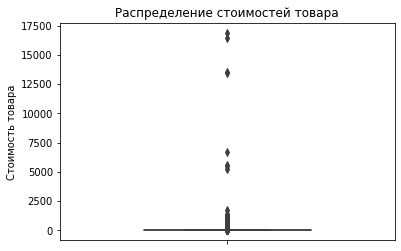

In [206]:
#поскольку у нас странное расределение стоимостей и наименований товара, попробуем посмотретьо на графике
sns.boxplot(y=products['price_per_one'], width=0.5)
plt.title('Распределение стоимостей товара')
plt.ylabel('Стоимость товара')
plt.show()


In [207]:
products['price_per_one'].describe ()

print (products ['price_per_one'].sort_values().tail(10))

9476    1435.79
8729    1715.85
9733    5258.77
4094    5519.25
9732    5575.28
4095    6706.71
4089   13474.79
3931   13541.33
6134   16453.71
6133   16888.02
Name: price_per_one, dtype: float64


In [208]:
#вычсилим, какому продукту принадлежат максимальный ценник
max_price = products[products['price_per_one'] == 16888.020000]
print (max_price)

#посмотрим, какая цена есть для MAZONFEE 
AMAZONFEE_price = products[products['product_id'] == 'AMAZONFEE']
print (AMAZONFEE_price)

     product_id  price_per_one
6133  AMAZONFEE       16888.02
     product_id  price_per_one
3891  AMAZONFEE           1.00
3931  AMAZONFEE       13541.33
4089  AMAZONFEE       13474.79
4094  AMAZONFEE        5519.25
4095  AMAZONFEE        6706.71
6133  AMAZONFEE       16888.02
6134  AMAZONFEE       16453.71
9732  AMAZONFEE        5575.28
9733  AMAZONFEE        5258.77


Вывод: пока не будем удалять значения с 0, это может быть бесплатный упаковочный товар, например, посмотрим на него в общей таблице.В то же время, на примере одного товара мы видим явные выбросы, поэтому для дальнейших рассчетов будем использовать медианное значение цены для каждого товара, чтобы сразу отсечь все выбросы.

Вывод: поскольку у нас очень много наименований товара, график получается не читамемым по оси X, но для нас это не так важно, - нам необходтимо было увидеть экстремальные выбросы. Их мы увидели. 
Далее нам необхолимо будет найти среднюю стоимость каждого товара. Предположительно покупатели могли купить их по любой их указанных цен. 

In [209]:
#составим таблтцу со средними значениями цены товара
products_new = products.groupby ('product_id') ['price_per_one'].median().reset_index()
products_new.columns = ['item_id', 'mean_price']
display (products_new)

,item_id,mean_price
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42
...,...,...
3154,gift_0001_20,16.84
3155,gift_0001_30,25.27
3156,gift_0001_40,34.04
3157,gift_0001_50,42.55


In [210]:
#объединяем таблицы (с чеками и с ценами товара) в одну
retail_new = pd.merge(retail, products_new, on='item_id')
retail_new ['income'] = retail_new ['mean_price'] * retail_new ['quantity']
display (retail_new)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,mean_price,income
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00,1.63,17.93
1,541104,21873,0,2017-01-13 14:29:00,NaN,Shop 0,0.00,1.63,0.00
2,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0.00,1.63,1.63
3,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0.00,1.63,3.26
4,541566,21873,35,2017-01-19 11:50:00,23401.00,Shop 0,1.00,1.63,57.05
...,...,...,...,...,...,...,...,...,...
105330,538852,90058B,35,2016-12-14 13:33:00,23051.00,Shop 0,1.00,0.38,13.30
105331,539988,46138B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.95,1.95
105332,537025,90053,0,2016-12-03 16:21:00,NaN,Shop 0,0.00,2.55,0.00
105333,542731,17028J,5,2017-01-31 15:27:00,19279.00,Shop 0,0.00,0.42,2.10


In [211]:
retail_new ['customer_id'].describe()

count   69125.00
mean    21019.30
std      1765.44
min     18025.00
25%     19544.00
50%     20990.00
75%     22659.00
max     23962.00
Name: customer_id, dtype: float64

In [212]:
print (retail_new ['income'].sum())

2031130.6150000002


In [213]:
#отфильтруем таблицу только по положительным значениям количества, это пригодится нам для просчета дохода, который получает магазин
retail_filtered_quantity = retail_new[retail_new['quantity'] > 0]
display (retail_filtered_quantity)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,mean_price,income
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00,1.63,17.93
2,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0.00,1.63,1.63
3,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0.00,1.63,3.26
4,541566,21873,35,2017-01-19 11:50:00,23401.00,Shop 0,1.00,1.63,57.05
5,538843,21873,1,2016-12-14 13:18:00,21712.00,Shop 0,0.00,1.63,1.63
...,...,...,...,...,...,...,...,...,...
105322,539988,16206B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.25,1.25
105327,539009,79329,5,2016-12-15 13:24:00,18900.00,Shop 0,0.00,1.65,8.25
105330,538852,90058B,35,2016-12-14 13:33:00,23051.00,Shop 0,1.00,0.38,13.30
105331,539988,46138B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.95,1.95


In [214]:
#посмотрим на данные в NaN customer_id
# Фильтрация строк с NaN в колонке 'customer_id'
retail_custome_nan = retail_new[retail_new['customer_id'].isna()]

# Отображение отфильтрованной таблицы
display(retail_custome_nan)


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,mean_price,income
1,541104,21873,0,2017-01-13 14:29:00,NaN,Shop 0,0.00,1.63,0.00
2,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0.00,1.63,1.63
3,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0.00,1.63,3.26
12,540352,21873,0,2017-01-06 14:27:00,NaN,Shop 0,0.00,1.63,0.00
13,539958,21873,0,2016-12-23 13:26:00,NaN,Shop 0,0.00,1.63,0.00
...,...,...,...,...,...,...,...,...,...
105323,545216,90157,0,2017-02-28 16:50:00,NaN,Shop 0,0.00,4.98,0.00
105324,538144,90042B,0,2016-12-09 15:58:00,NaN,Shop 0,0.00,0.00,0.00
105325,539740,85035b,0,2016-12-21 15:20:00,NaN,Shop 0,0.00,8.47,0.00
105329,540560,21589,-15,2017-01-10 10:08:00,NaN,Shop 0,0.00,0.00,-0.00


In [215]:
print (retail_custome_nan ['loyalty_program'].unique())
print (retail_custome_nan ['shop_id'].unique())

[0.]
['Shop 0' 'Shop 6' 'Shop 25' 'Shop 21' 'Shop 23']


In [216]:
nan_count = retail_new['customer_id'].isna().sum()
print (nan_count)

36210


Вывод: несмотря на то, что у нас больше количество неопредленных покупателей, заполнить эти пропуски мы никак не сможем. Придется работать, с чем есть. Для анализа покупок мы отфильтруем таблицу, убрав оттуда все значения ниже нуля - возвраты, а к ним вернемся, когда будем изучать процент возвратов.

In [217]:
#таблица без отрицательных значений
retail_new_clean = retail_new[retail_new['quantity'] > 0]
display (retail_new_clean )

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,mean_price,income
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00,1.63,17.93
2,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0.00,1.63,1.63
3,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0.00,1.63,3.26
4,541566,21873,35,2017-01-19 11:50:00,23401.00,Shop 0,1.00,1.63,57.05
5,538843,21873,1,2016-12-14 13:18:00,21712.00,Shop 0,0.00,1.63,1.63
...,...,...,...,...,...,...,...,...,...
105322,539988,16206B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.25,1.25
105327,539009,79329,5,2016-12-15 13:24:00,18900.00,Shop 0,0.00,1.65,8.25
105330,538852,90058B,35,2016-12-14 13:33:00,23051.00,Shop 0,1.00,0.38,13.30
105331,539988,46138B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.95,1.95


In [219]:
retail_new_clean ['purchase_date'].describe()

/tmp/ipykernel_30/256987447.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  retail_new_clean ['purchase_date'].describe()


count                   70162
unique                   3468
top       2016-12-06 16:57:00
freq                      331
first     2016-12-01 08:26:00
last      2017-02-28 17:01:00
Name: purchase_date, dtype: object

<b>Вывод:</b>
В этой части мы провели предобработку данных: удалили дубликаты, переименовали колонки для удобства дальнейшего анализа данных, вычислили медианные значения цены каждого товара, удалили выбросы и аномалии, а также совместили таблицы. 

Теперь можем приступать к исследовательскому анализу данных. 

### Часть 3. Исследовательский анализ данных

Цели и задачи: 
1) Изучение отдельных магазинов: количество покупок, выручка. 

2) Изучение разных товаров и услуг: самые популярные продукты, частота заказа доствки. 

3) Изучение средней цены чека по магазинам, количества позиций в чеке. 

4) Самые популярные дни недели для покупок: в какие дни больше всего покупок, в какие дни самый высокий средний чек. 

5) Количество покупок по программе лояльности и без (в качесстве первого показателя). 

In [133]:
#посчитаем количество уникальных покупок в каждом магазине
shops_group = retail_new_clean.groupby ('shop_id')['purchase_id'].nunique().reset_index ()
shops_group.columns = ['shop_id', 'purchase_count']
shops_group = shops_group.sort_values (by = 'purchase_count', ascending = False)

#shops_group ['income'] = retail_new.groupby('shop_id').apply(lambda x: (x['quantity'] * x['mean_price']).sum())

display (shops_group)

,shop_id,purchase_count
0,Shop 0,3383
25,Shop 4,79
1,Shop 1,70
27,Shop 6,37
12,Shop 2,17
4,Shop 12,16
29,Shop 8,16
23,Shop 3,13
2,Shop 10,12
28,Shop 7,10


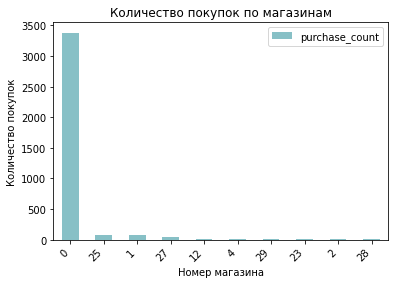

In [134]:
#посмотрим график общего количество покупок в 10 магазинах

shops_group.head (10).plot(kind='bar', color = '#87C0C6')
plt.xticks(rotation=45, ha='right')
plt.title('Количество покупок по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Количество покупок')
plt.show()

In [135]:
#проверим общую выручку магазинов по таблице с отрицательными значениями
retail_new_clean = retail_new_clean.copy()
retail_new_clean['income'] = retail_new['quantity'] * retail_new['mean_price']
display(retail_new_clean)


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,mean_price,income
0,538280,21873,11,2016-12-10 12:50:00,18427.00,Shop 0,0.00,1.63,17.93
2,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0.00,1.63,1.63
3,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0.00,1.63,3.26
4,541566,21873,35,2017-01-19 11:50:00,23401.00,Shop 0,1.00,1.63,57.05
5,538843,21873,1,2016-12-14 13:18:00,21712.00,Shop 0,0.00,1.63,1.63
...,...,...,...,...,...,...,...,...,...
105322,539988,16206B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.25,1.25
105327,539009,79329,5,2016-12-15 13:24:00,18900.00,Shop 0,0.00,1.65,8.25
105330,538852,90058B,35,2016-12-14 13:33:00,23051.00,Shop 0,1.00,0.38,13.30
105331,539988,46138B,1,2016-12-23 16:06:00,23795.00,Shop 0,1.00,1.95,1.95


In [136]:
shops_group_income = retail_new_clean.groupby('shop_id')['income'].sum().reset_index()
shops_group_income = shops_group_income.sort_values (by = 'income', ascending = False)
pd.options.display.float_format = '{:.2f}'.format
display (shops_group_income)

,shop_id,income
0,Shop 0,1967824.66
23,Shop 3,102070.05
27,Shop 6,62468.20
25,Shop 4,53851.40
1,Shop 1,48615.33
12,Shop 2,39651.93
6,Shop 14,22346.06
29,Shop 8,17188.25
11,Shop 19,11299.83
28,Shop 7,11271.10


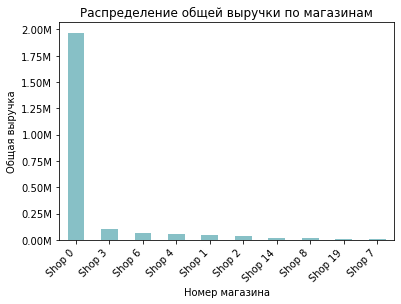

In [137]:
#посмотрим график общей выручки по магазинам 

def millions_formatter(x, pos):
    return f'{x / 1_000_000:.2f}M'

formatter = FuncFormatter(millions_formatter)

ax = shops_group_income.head(10).plot(kind='bar', color='#87C0C6', legend=None)
ax.yaxis.set_major_formatter(formatter)

plt.xticks(range(0, 10), shops_group_income['shop_id'].head(10), rotation=45, ha='right')
plt.title('Распределение общей выручки по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Общая выручка')
plt.show()

In [138]:
# проверим самые популярные продукты по таблице без отрицательных знеачений

products_popular = retail_new_clean.groupby ('item_id')['quantity'].sum().reset_index()
products_popular = products_popular.sort_values (by = 'quantity', ascending = False)
display (products_popular.head (10))

,item_id,quantity
1763,23166,74214
2505,85123A,10614
2113,84077,10126
382,21212,9325
2487,85099B,7616
1014,22197,6954
1465,22693,6830
1392,22616,5764
1840,37413,5672
1255,22469,5602


In [139]:

deliver_count_not_clean = (retail_new['item_id'] == 'DOT').sum()
print ('Количество заказов доставки:', deliver_count_not_clean)

Количество заказов доставки: 175


In [140]:
#Изучение средней выручки по магазинам
shops_group_income_mean = retail_new_clean.groupby('shop_id')['income'].mean()
shops_group_income_mean = shops_group_income_mean.reset_index ()
shops_group_income_mean = shops_group_income.sort_values (by = 'income', ascending = False)
pd.options.display.float_format = '{:.2f}'.format
display (shops_group_income_mean)

,shop_id,income
0,Shop 0,1967824.66
23,Shop 3,102070.05
27,Shop 6,62468.20
25,Shop 4,53851.40
1,Shop 1,48615.33
12,Shop 2,39651.93
6,Shop 14,22346.06
29,Shop 8,17188.25
11,Shop 19,11299.83
28,Shop 7,11271.10


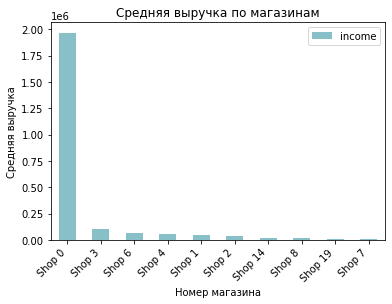

In [141]:
shops_group_income_mean.head(10).plot(x='shop_id', y='income', kind='bar', color='#87C0C6')
plt.xticks(rotation=45, ha='right')
plt.title('Средняя выручка по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Средняя выручка')
plt.show()

In [142]:
#посчитаем количество товара позиций в чеке
purchase_item_count = retail_new_clean.groupby ('purchase_id')['item_id'].count().reset_index()
purchase_item_count = purchase_item_count.sort_values(by = 'item_id', ascending = False)

display (purchase_item_count)

,purchase_id,item_id
520,537434,331
1537,539958,309
793,538071,306
1791,540551,294
280,536876,294
...,...,...
826,538137,1
3292,544312,1
827,538138,1
828,538139,1


In [143]:
#посчитаем среднее количество позиций в чеке в разрезе по магазинам
shop_item_mean = retail_new_clean.groupby(['shop_id', 'purchase_id'])['item_id'].nunique().reset_index()
shop_item_mean.columns = ['shop_id', 'purchase_id', 'item_count']
shop_item_mean = shop_item_mean.reset_index()
mean_item_per_purchase = shop_item_mean.groupby('shop_id')['item_count'].mean().reset_index()
mean_item_per_purchase.columns = ['shop_id', 'mean_item_count']
mean_item_per_purchase = mean_item_per_purchase.sort_values (by = 'mean_item_count', ascending = False)

display(mean_item_per_purchase)

,shop_id,mean_item_count
19,Shop 26,56.00
18,Shop 25,47.00
20,Shop 27,45.00
26,Shop 5,44.50
23,Shop 3,37.00
10,Shop 18,35.50
17,Shop 24,32.00
29,Shop 8,31.44
28,Shop 7,30.90
7,Shop 15,30.00


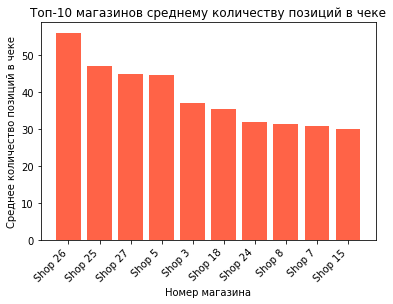

In [144]:
shops_top10_mip = mean_item_per_purchase.head(10)
plt.bar(shops_top10_mip['shop_id'], shops_top10_mip['mean_item_count'], color='#FF6347')
plt.title('Топ-10 магазинов среднему количеству позиций в чеке')
plt.xlabel('Номер магазина')
plt.ylabel('Среднее количество позиций в чеке')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show() 


In [145]:
#изучим, в какие дни больше всего покупок - самая большая выручка
retail_new_clean ['weekday'] = retail_new_clean ['purchase_date'].dt.day_name()

#display (retail_new.head (10))
weekday_income = retail_new_clean.groupby ('weekday')['income'].sum().reset_index ()
weekday_income = weekday_income.sort_values (by = 'income', ascending = False)
display (weekday_income)


,weekday,income
5,Wednesday,590417.39
0,Friday,453496.40
3,Thursday,416460.97
2,Saturday,412388.82
4,Tuesday,384100.83
1,Monday,147249.19


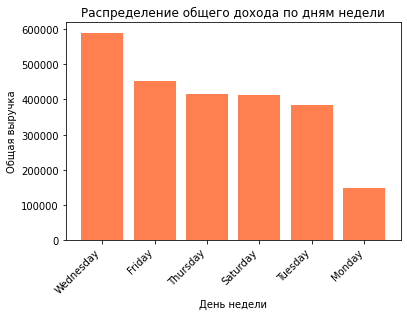

In [146]:
plt.bar(weekday_income['weekday'], weekday_income['income'], color='#FF7F50')
plt.title('Распределение общего дохода по дням недели')
plt.xlabel('День недели')
plt.ylabel('Общая выручка')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show() 

In [147]:
#в какие дни недели самый высокий средний чек 

grouped_weekday_income = retail_new_clean.groupby(['purchase_id', 'weekday'])['income'].sum().reset_index()

mean_income_per_weekday = grouped_weekday_income.groupby('weekday')['income'].mean().reset_index()
mean_income_per_weekday.columns = ['weekday', 'mean_income']
mean_income_per_weekday = mean_income_per_weekday.sort_values (by = 'mean_income', ascending = False)

display(mean_income_per_weekday)

,weekday,mean_income
5,Wednesday,923.97
2,Saturday,709.79
4,Tuesday,627.62
0,Friday,572.60
3,Thursday,571.28
1,Monday,412.46


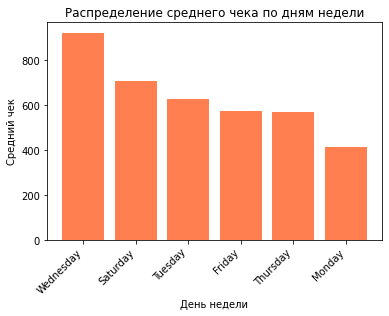

In [148]:
plt.bar(mean_income_per_weekday['weekday'], mean_income_per_weekday['mean_income'], color='#FF7F50')
plt.title('Распределение среднего чека по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средний чек')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show() 

<b>Вывод: </b>
    
Провели исследовательский анализ данных о продажах в строительном магазине: 
- топ магазинов по количество покупок: Shop 0 - 3383, Shop 4 - 79, Shop 1 - 70;
- количество заказов доставки: 175;
- топ-3 магазинов по общему доходу: Shop 0 - 1 967 824, 06, Shop 3 - 102 070,05, Shop 6 - 62 468, 20;
- наиболее успешные магазины по количеству позиций в чеке: Shop 26 - 56, Shop 25 - 47, Shop 27 - 45, Shop 5 - 44,50;
- распределение общего дохода по дням недели: самая большая выручка - в среду (590 417,39 р.), чуть меньше в пятницу (453 496.40 р.) и в четверг (416 460.97 р.);
- наиболее высокий средений чек в разрезе по дням недели: в среду (923.97  р.), субботу (709.79  р.) и четверг (627.62 р.).

### Часть 4. Решение основных вопросов заказчика

1) Исследования количества покупок по карте лояльности и без.

2) Исследование возратов по карте лояльности и без.

3) Исследование повторных покупок у покупателей по карте лояльности и без.

4) Исследование среднего чека покупок по карте лояльности и без. 

5) Количество общей выручки по картам лояльности и без.

In [149]:
# посчитаем количество покупок по уникальным чекам
purchase_sum = retail_new_clean['purchase_id'].nunique()

# посчитаем количество покупок по карте лояльности
filtered_loyalty = retail_new_clean[retail_new_clean['loyalty_program'] == 1.0]
filtered_non_loyalty = retail_new_clean[retail_new_clean['loyalty_program'] == 0.0]
purchase_sum_loyalty = filtered_loyalty['purchase_id'].nunique()
purchase_sum_non_loyalty = filtered_non_loyalty['purchase_id'].nunique()

print('Количество уникальных чеков/покупок:', purchase_sum)
print('Количество покупок по программе лояльности:', purchase_sum_loyalty) 
print('Процент покупок по программе лояльности:', round(purchase_sum_loyalty / purchase_sum * 100, 2)) 
print('Процент покупок без карты лояльности:', round(purchase_sum_non_loyalty / purchase_sum * 100, 2))

Количество уникальных чеков/покупок: 3710
Количество покупок по программе лояльности: 1120
Процент покупок по программе лояльности: 30.19
Процент покупок без карты лояльности: 69.81


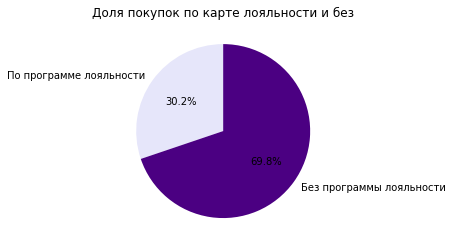

In [150]:
pie_data = [purchase_sum_loyalty, purchase_sum - purchase_sum_loyalty]

colors = ['#E6E6FA', '#4B0082']

labels = ['По программе лояльности', 'Без программы лояльности']

plt.pie(pie_data, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title('Доля покупок по карте лояльности и без')

plt.show()

In [151]:
#посчитаем количество покупателей по карте лояльности и без
customer_unique = retail_new_clean['customer_id'].nunique()
customer_sum_loyalty = filtered_loyalty ['customer_id'].nunique()
customer_sum_non_loyalty = filtered_non_loyalty ['customer_id'].nunique()


print('Количество клиентов:', customer_unique)
print('Количество клиентов по лояльной программе:', customer_sum_loyalty)
print('Процент клиентов по программе лояльности:', round (customer_sum_loyalty/customer_unique*100,2))
print('Процент клиентов без программы лояльности:', round (customer_sum_non_loyalty/customer_unique*100,2))


Количество клиентов: 1671
Количество клиентов по лояльной программе: 561
Процент клиентов по программе лояльности: 33.57
Процент клиентов без программы лояльности: 66.43


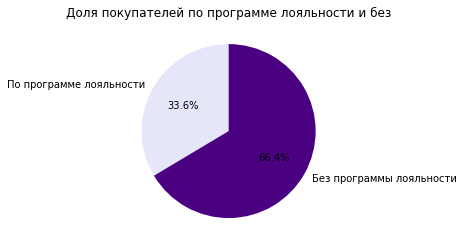

In [152]:
pie_customer_loyalty = [customer_sum_loyalty, customer_unique - customer_sum_loyalty]
colors = ['#E6E6FA', '#4B0082']

labels = ['По программе лояльности', 'Без программы лояльности']

plt.pie(pie_customer_loyalty, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title('Доля покупателей по программе лояльности и без')

plt.show()

In [153]:
#исследование повторных покупок у покупателей по карте лояльности и без - как часто совершают повторные покупки по карте лояльности
loyalty_program = retail_new_clean[retail_new_clean['loyalty_program'] == 1.0]
non_loyalty_program = retail_new_clean[retail_new_clean['loyalty_program'] == 0.0]

loyalty_grouped = loyalty_program.groupby('customer_id')['purchase_id'].nunique().reset_index()
non_loyalty_grouped = non_loyalty_program.groupby('customer_id')['purchase_id'].nunique().reset_index()

mean_purchases_loyalty = loyalty_grouped['purchase_id'].mean()
mean_purchases_non_loyalty = non_loyalty_grouped['purchase_id'].mean()

print(f"Среднее количество покупок с участием в программе лояльности: {mean_purchases_loyalty:.2f}")
print(f"Среднее количество покупок без участия в программе лояльности: {mean_purchases_non_loyalty:.2f}")


Среднее количество покупок с участием в программе лояльности: 2.00
Среднее количество покупок без участия в программе лояльности: 1.99


In [154]:
#исследование среднего чека покупок по карте лояльности и без 


total_purchase = retail_new_clean.groupby('purchase_id').agg({
    'income': 'sum',
    'loyalty_program': 'first',
    'customer_id': 'first'
})

mean_bill_loyalty = total_purchase.groupby('loyalty_program').agg({'income': 'mean'}).reset_index()

display(mean_bill_loyalty)

,loyalty_program,income
0,0.00,699.50
1,1.00,528.95


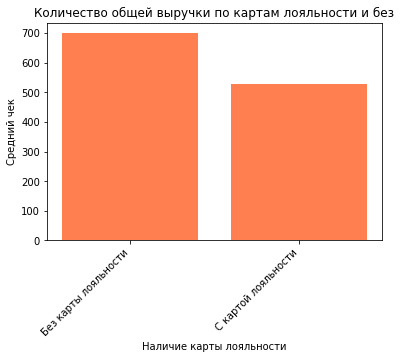

In [155]:
fig, ax = plt.subplots()
labels = ['Без карты лояльности', 'С картой лояльности']
bars = ax.bar(mean_bill_loyalty['loyalty_program'], mean_bill_loyalty['income'], color='#FF7F50', tick_label=labels)
ax.set_title('Количество общей выручки по картам лояльности и без')
ax.set_xlabel('Наличие карты лояльности')
ax.set_ylabel('Средний чек')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [156]:
#количество общей выручки по картам лояльности и без
sum_bill_loyalty = total_purchase.groupby('loyalty_program').agg({'income': 'sum'}).reset_index ()
display(sum_bill_loyalty)

,loyalty_program,income
0,0.00,1811692.80
1,1.00,592420.79


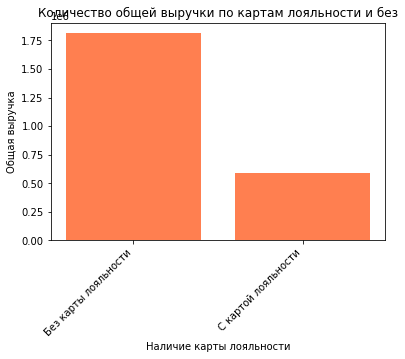

In [157]:
fig, ax = plt.subplots()
labels = ['Без карты лояльности', 'С картой лояльности']
bars = ax.bar(sum_bill_loyalty['loyalty_program'], sum_bill_loyalty['income'], color='#FF7F50', tick_label=labels)
ax.set_title('Количество общей выручки по картам лояльности и без')
ax.set_xlabel('Наличие карты лояльности')
ax.set_ylabel('Общая выручка')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

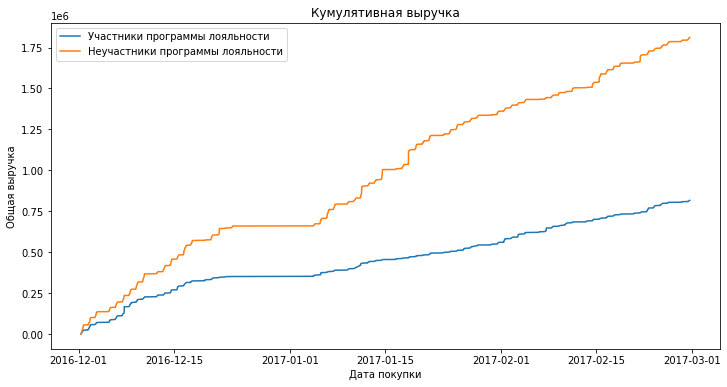

In [158]:
#рассчитаем кумулятивную выручку по каждой из групп

loyalty_members = retail_new_clean[retail_new_clean['loyalty_program'] == 1.0]
non_loyalty_members = retail_new_clean[retail_new_clean['loyalty_program'] == 0]
loyalty_grouped = loyalty_members.groupby(['purchase_date', 'customer_id'])['income'].sum().reset_index()
loyalty_grouped['income'] += 200
loyalty_grouped = loyalty_grouped.groupby('purchase_date')['income'].sum()
non_loyalty_grouped = non_loyalty_members.groupby('purchase_date')['income'].sum()

cumulative_loyalty = np.cumsum(loyalty_grouped)
cumulative_non_loyalty = np.cumsum(non_loyalty_grouped)

# Построение графика LTV для каждой группы
plt.figure(figsize=(12, 6))
plt.plot(cumulative_loyalty.index, cumulative_loyalty.values, label='Участники программы лояльности')
plt.plot(cumulative_non_loyalty.index, cumulative_non_loyalty.values, label='Неучастники программы лояльности')
plt.xlabel('Дата покупки')
plt.ylabel('Общая выручка')
plt.title('Кумулятивная выручка')
plt.legend()
plt.show()

In [220]:
def get_ltv(loyalty_group, non_loyalty_group, observation_date, horizon_days, dimensions=[]):    
    
    loyalty_group = loyalty_group.copy()
    non_loyalty_group = non_loyalty_group.copy()

    def calculate_ltv(group):
        income_per_user = group.groupby('customer_id')['income'].sum()
        mean_income = income_per_user.mean()
        
        if 'loyalty' in group['group'].unique():
            mean_income += 200
        purchase_count = group.groupby('customer_id')['purchase_id'].nunique()
        mean_purchases = purchase_count.mean()
        ltv = round(mean_income * mean_purchases, 2)

        return ltv

    # Добавляем новую колонку 'group' для каждого датафрейма
    loyalty_group['group'] = 'loyalty'
    non_loyalty_group['group'] = 'non_loyalty'

    groups_common = pd.concat([loyalty_group, non_loyalty_group])

    last_suitable_purchase_date = observation_date - timedelta(days=horizon_days - 1)
    
    result_raw = groups_common.query('purchase_date <= @last_suitable_purchase_date')
    
    if len(dimensions) == 0:
        dimensions = ['group']
    else:
        dimensions = dimensions + ['group']

    result_grouped = result_raw.groupby(dimensions, as_index=False).apply(calculate_ltv)
  
    return result_grouped

observation_date = pd.to_datetime('2017-02-28')
horizon_days = 60

ltv_results = get_ltv(loyalty_members, non_loyalty_members, observation_date, horizon_days)

print(ltv_results)

         group     NaN
0      loyalty 1548.50
1  non_loyalty 1508.65


Вывод: LTV покупателей в разрезе 60 дней  по программе лояльности чуть выше, чем покупателей без карты лояльности. Соответственно, можно считать, что внедрение программы лояльности выгодно для бизнеса, и, возможно, в будущем будет приносить больше прибыли. 


Вывод: 
- Общее количество клиентов: 1671, из них по карте лояльности 33.57 %. Сложно оценить вовлеченность по этой цифре, посколько у нас нет информации о преиоде продаж карты лояльности, а также маркетинговых активностях, которые проводились для этого. 
- Общее количество уникальных чеков/покупок: 3710, из них 30.19% по карте лояльности. В целом процент покупок по карте лояльности чуть ниже, чем процент покупателей с картой лояльности. В целом - этоне самый хороший сигнал, получается, что люли с картой лояьности покупают реже. 
- Среднее количество покупок с участием в программе лояльности: 2.00. Среднее количество покупок без участия в программе лояльности: 1.99. Соответственно, отличается совсем не значительно. 
- Средний чек без карты лояльности - 699.5 р., по карте лояльности 528.95  р. Показатель, который говорит о том, что карта лояльности снижает средний чек. 
- Общий доход, который принесли магазины покупатели без карты лояльности - 1 811 692.80 р . , по карте лояльности 592 420.79 р. Разница, скорее всего обусловлена тем, что покупателей по карте лояльности - только терть. 
- График кусулятивной выручки также подтверждает, что покупатели без карты лояльности приносят больше прибыли, чем покупатели по карте лояльности. При этом необходимо учесть, что в расчете кумулятивной выручке учтена так же и стоимость самой карты лояльности, им даже в этой случае график покупателей с картой лояльности выглядит менее привклекательно. 
- Вывод: LTV покупателей в разрезе 60 дней  по программе лояльности чуть выше, чем покупателей без карты лояльности. Соответственно, можно считать, что внедрение программы лояльности выгодно для бизнеса, и, возможно, в будущем будет приносить больше прибыли. 

### Часть 5.   Проверка статистических гипотез

1) Cредний чек участников программы лояльности выше, чем у остальных покупателей. 

2) Покупатели по карте лояльности чаще возвращются в магазины, чем без.

Нулевая гипотеза H0: Средний чек покупки по карте лояльности равен среднему чеку покупателя без карты лояльности.
Альтернативной гипотезой H1 будем считать, что средний чек покупки по карте лояльности не равен среднему чеку покупателя без карты лояльности.

Для проверки гипотезы будем использовать матод Манна-Уитни. 

In [95]:
loyalty_bills = total_purchase[total_purchase['loyalty_program'] == 1]['income']
no_loyalty_bills = total_purchase[total_purchase['loyalty_program'] == 0]['income']

u_stat, p_value = stats.mannwhitneyu(loyalty_bills, no_loyalty_bills, alternative='greater')

# Если p_value меньше 0.05, гипотеза о том, что средний чек участников программы лояльности выше, подтверждается.
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу. Средний чек покупки по карте лояльности выше.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Разница в средних чеках не является статистически значимой.")


Не удалось отвергнуть нулевую гипотезу. Разница в средних чеках не является статистически значимой.


Нулевая гипотеза H0: доля повторных покупок среди покупателей с картой лояльности равна доле повторных покупок среди покупателей без карты лояльности.
Альтернативная гипотеза H1: доля повторных покупок среди покупателей с картой лояльности выше, чем доля повторных покупок среди покупателей без карты лояльности.

In [90]:
customer_purchase = retail_new_clean.groupby(['customer_id', 'loyalty_program']).agg({'purchase_id': 'nunique'}).reset_index()


customers_loyalty = customer_purchase[customer_purchase['loyalty_program'] == 1]
customers_no_loyalty = customer_purchase[customer_purchase['loyalty_program'] == 0]

customers_loyalty_rep = (customers_loyalty['purchase_id'] > 1).sum()
customers_no_loyalty_rep = (customers_no_loyalty['purchase_id'] > 1).sum()

count = [customers_loyalty_rep, customers_no_loyalty_rep]
nobs = [len(customers_loyalty), len(customers_no_loyalty)]

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу. Покупатели с картой лояльности чаще совершают повторные покупки.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Доля повторных покупок примерно одинакова")

Отвергаем нулевую гипотезу. Покупатели с картой лояльности чаще совершают повторные покупки.


Вывод по проверке статистических гипотез: из результатов нашей статистической проверки можно сделать вывод, что при отсутствии разницы в средних чеках, покупатели с картой лояльности часще совершают повторные покупки. Соответственно, в будущем программа лояльности может стать весьма успешной в будущем. 

### Общие выводы


<b>Некоторые особенности данных в дата-сетах:</b> 
- не распреледелнная активность магазинов, больше всего продаж в Shop 0,
- невысокий процент участников программы лояльности среди покупателей магазинов, 
- отсутствие точных данных о цене продажи товар;
- отсутствие информации о доступных привелегиях по карте лояльности: скидки, подарки и тд;
- неизвестно количество отаказов в приобритении карты лоряльности. 

<b>Основные выоводы по результатам работы карты лояльности: </b>
По многим основынм важным показателям, например, среднему чеку, пользователи по карте лояльности незначительно устпуают пользователям без карты лояльности. Рассчет кумулятивной выручки также показывает, что покупатели без карты лояльности приносят больше прибыли, чем покупатели по карте лояльности. При этом необходимо учесть, что в ней учтена так же и стоимость самой карты лояльности, им даже в этой случае график покупателей с картой лояльности выглядит более плавным. 

Расчет LTV показал, что в среднем пользователи без карты лояльности приносят меньше дохода, чем пользователи по карте лояльности. Исходя из этого, следует сделать вывод, что на текущий момент - программа лояльности уже выгодня для бизнеса, однако разница пока не значительная и обеспечивается отчасти за счет продажти самой карты лояльности. 

Тем не менее, следует обратить на результаты статистической проверки.При отсутствии разницы в средних чеках, покупатели с картой лояльности часще совершают повторные покупки. Соответственно, в будущем программа лояльности может стать весьма успешной. 

<b> Общие рекомендации:</b>
1. Продолжить эксперимент с внедрение карты лояльности и увеличить долю участников программы лояльности. 
2. Необходимо точнее учитываать стоимость проданного товара по реальной цене (возможны корреляции), а так же уточнить, нет ли скидок по карте лояльности. 
3. Усилить работу по увеличеению среднего чека покупателей с картой лояльности, скорее всего, в этом случае, доход от пользователей по карте лояльности будет занимать бОльшую долю. 

In [101]:
#выгружаем файл для дальнейшего использования Tableu 
retail_new_clean.to_csv('retail_new_clean')

Презентация: https://disk.yandex.ru/i/XREphY18ThMJEQ

Дашборд: https://public.tableau.com/app/profile/kseniya.sidunova/viz/___16817365931490/Dashboard1 